In [1]:
import os

import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import math


In [2]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [3]:
def get_sigloch_stf(sigloch_name):
    data_path = '/home/siglochnas1/shared/AmplitudeProjects/pdata_processed/psdata_events/'
    momentrate = []
    time = []

    file_path = data_path + str(sigloch_name) + '/outfiles/ampinv.stf.xy'

    with open(file_path, 'r') as file:
        content = file.read()
        content = content.split('\n')
        greater_than_count = content.count('>')
        if greater_than_count > 0:
            time = [[]]
            momentrate = [[]]
            for i in range(greater_than_count-1):
                time.append([])
                momentrate.append([])


        stf_count = 0
        for c in content:
            if c not in ['<', '>', '']:
                split = c.split()
                time[stf_count].append(float(split[0]))
                momentrate[stf_count].append(float(split[1]))
            else:
                stf_count += 1
    momentrate = np.array(momentrate)
    time = np.array(time)
    return momentrate, time

In [4]:
def get_scardec_stf(scardec_name, wanted_type = 'fctopt'):
    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    time = np.array(time)
    return momentrate, time

In [5]:
def get_usgs_stf(usgs_name):
    data_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/USGS/'
    momentrate = []
    time = []

    with open(data_path + str(usgs_name), 'r') as f:
        data = f.readlines()
        for line in data:
            line = line.strip()
            line = line.rstrip()
            if line[0] not in ['0','1','2','3','4','5','6','7','8','9']:
                continue
            line = line.split()
            time.append(float(line[0]))
            momentrate.append(float(line[1]))

    momentrate = np.array(momentrate)
    time = np.array(time)

    momentrate = momentrate / 10**7 # convert to Nm from dyne cm
    return momentrate, time

In [6]:
def find_end_stf(momentrate, time):
    #print(momentrate)
    not_zero = np.where(momentrate > 0)[0]
    #print(max(momentrate))
    start = min(not_zero)
    end = max(not_zero)
    #print(end)

    detected_end = end
    detected_end_time = time[end]

    time = time[:end]
    momentrate = momentrate[:end]

    #print(momentrate)

    less_than_10 = np.where(momentrate <= 10*max(momentrate)/100)[0]
    #print(less_than_10)
    total_moment = scipy.integrate.simpson(momentrate[0:end],
                                        dx = time[1]-time[0])
    #print(less_than_10)
    for i in less_than_10:
        if i == 0:
            continue
        moment = scipy.integrate.simpson(momentrate[0:i],
                                        dx = time[1]-time[0])
        #print(i, moment/total_moment)
        if moment >= 0.5 * total_moment:
            #print('inif')
            #print(f'first time where < 10% of total momentrate and 50% of moment released: {time[i]} s')
            detected_end_time = time[i]
            detected_end = i
            #print(f'proportion of moment released: {(moment/total_moment)*100:.2f}%')
            break
    return detected_end_time, detected_end, time[start], start
    #return time[end], end

In [7]:
# looks for time value of root
def f3(end_time, total_moment, time_opt, momentrate_opt, start, points_before_zero, proportion = 0.1):

    dx = time_opt[1]-time_opt[0]
    end_window = (end_time/dx)+points_before_zero
    end = int(np.floor(end_window))
    #print(start, end)
    if start == end:
        end += 1
    short = scipy.integrate.simpson(momentrate_opt[start:end], dx = dx)
    return short-(total_moment*proportion)

In [8]:
def plot_scatter_figures(proportion, root_times, moments, durations):
    root_times = np.array(root_times)
    moments = np.array(moments)
    durations = np.array(durations)

    plt.scatter(root_times, durations, c = np.log10(moments), cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('Duration (s)')
    plt.xlabel(f'time to release {proportion*100}% of moment (s)')
    plt.colorbar(label = 'log10(moment)')
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_{proportion*100}_percent_moment_against_duration.png')
    plt.close()

    plt.scatter(root_times, np.log10(moments), c = durations, cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('log10(moment)')
    plt.xlabel(f'time to release {proportion*100}% of moment (s)')
    plt.colorbar(label = 'Duration (s)')
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_{proportion*100}_percent_moment_against_moment.png')
    plt.close()

    plt.scatter(root_times/durations, np.log10(moments), c = durations, cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('log10(moment)')
    plt.xlabel(f'proportion of duration to release {proportion*100}% of moment')
    plt.colorbar()
    plt.xlim(0, 1)
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/fraction_of_duration_for_{proportion*100}_percent_moment_against_moment.png')
    plt.close()

In [9]:
def plot_hist_figures(proportion, root_times, durations):
    root_times = np.array(root_times)
    durations = np.array(durations)

    plt.hist(root_times/durations, bins = 100)

    plt.ylabel('Frequency')
    plt.xlabel(f'Proportion of duration to release {proportion*100}% of moment')
    plt.xlim(0, 1)
    plt.show()
    #plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/histogram_fraction_of_duration_for_{proportion*100}_percent_moment.png')
    #plt.close()

In [10]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined_scardec_ye_usgs_sigloch_isc_mag.csv')
combined.columns = ['event', 'scardec', 'ye', 'isc', 'sigloch', 'usgs', 'mag']

In [11]:
proportions_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

all_durations = []
all_root_times = []
all_moments = []
all_relative_root_times = [[]]
all_relative_root_times_for_event = {}

to_ignore = ['20051203_1610_1', '20071226_2204_2', '20030122_0206_1', '20090929_1748_0', '20120421_0125_1', '20110311_2011_2']

for proportion in proportions_list:
    print(proportion)
    durations = []
    root_times = []
    relative_root_times = []

    diff = []
    moments = []

    for i, row in combined.iterrows():

        name = row['sigloch']
        if name == '0' or name == 0:
            continue

        #print(scardec_name)
        momentrate, time = get_sigloch_stf(name)
        momentrate = 10**momentrate

        momentrate_list, time_list = get_sigloch_stf(row['sigloch'])
        count = 0
        for momentrate, time in zip(momentrate_list, time_list):
            momentrate = np.array(momentrate)
            time = np.arange(0, 25.6, 0.1)#np.array(time)
            detected_end_time, detected_end, detected_start_time, detected_start = find_end_stf(10**momentrate, time)
            time = time - detected_start_time # shift to start STF at zero
            detected_end_time = detected_end_time - detected_start_time

            detected_end_time, detected_end, detected_start_time, detected_start = find_end_stf(momentrate, time)
            time = time - detected_start_time # shift to start STF at zero
            detected_end_time = detected_end_time - detected_start_time

            not_zero = np.where(momentrate > 0)[0]

            dx = time[1]-time[0]

            start = 0 # min(not_zero)
            end = detected_end - detected_start # max(not_zero)
            points_before_zero = 0 # abs(min(time)/dx)

            duration = detected_end_time
            durations.append(duration)

            start_time = 0
            end_time = detected_end_time

            total_moment = scipy.integrate.simpson(momentrate[0:end], dx = dx)
            moments.append(total_moment)
            try:
                root, r = scipy.optimize.bisect(f3,
                                                start_time+dx,
                                                end_time-dx,
                                                rtol = 1e-6,
                                                full_output = True,
                                                args = (total_moment,
                                                        time,
                                                        momentrate,
                                                        start,
                                                        points_before_zero,
                                                        proportion,))
            except ValueError:
                print('value error')
                print(name)
                durations = durations[:-1]
                moments = moments[:-1]
                continue
            save_key = row.event + '_' + str(count)
            if save_key not in to_ignore:

                root_idx = np.floor(root/dx)
                root_time = root_idx*dx
                root_times.append(root_time)
                relative_root_times.append(root_time-start_time)
            else:
                durations = durations[:-1]
                moments = moments[:-1]


            if save_key in all_relative_root_times_for_event.keys():
                to_save = all_relative_root_times_for_event[save_key]
                to_save.append((root_time-start_time)/duration)
                all_relative_root_times_for_event[save_key] = to_save
            else:
                all_relative_root_times_for_event[save_key] = [(root_time-start_time)/duration]

            count += 1

        if proportion == 0.1 and (root_time-start_time)/duration > 0.8:
            print('long initial time')
            print(row.event)
            print(save_key)

        # if root_time-start_time > duration:
        #     print('root time greater than duration, proportion:', proportion)
        #     print(name)


    root_times = np.array(root_times)
    # print(root_times)
    durations = np.array(durations)
    moments = np.log10(np.array(moments))
    relative_root_times = np.array(relative_root_times)

    rel_root_times = relative_root_times/durations
    all_root_times.append(root_times[0])
    all_relative_root_times.append(list(rel_root_times))


0.1
value error
0061.2007.187.a
0.2
value error
0061.2007.187.a
0.3
value error
0061.2007.187.a
0.4
value error
0061.2007.187.a
0.5
value error
0061.2007.187.a
0.6
value error
0061.2007.187.a
0.7
value error
0061.2007.187.a
0.8
value error
0061.2007.187.a
0.9
value error
0061.2007.187.a


In [15]:
df = pd.DataFrame.from_dict(all_relative_root_times_for_event, orient='index', columns=['10', '20', '30', '40', '50', '60', '70', '80', '90'])

In [16]:
df.save_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/sigloch_relative_root_times.csv')

,10,20,30,40,50,60,70,80,90
20110126_1542_0,0.105882,0.207843,0.301961,0.392157,0.486275,0.584314,0.694118,0.792157,0.894118
20011012_1502_0,0.098039,0.188235,0.294118,0.396078,0.494118,0.596078,0.694118,0.796078,0.901961
20011012_1502_1,0.098039,0.180392,0.274510,0.380392,0.486275,0.592157,0.686275,0.792157,0.894118
20011012_1502_2,0.074510,0.168627,0.266667,0.376471,0.474510,0.584314,0.686275,0.792157,0.894118
20120320_1802_0,0.105882,0.207843,0.305882,0.403922,0.494118,0.584314,0.686275,0.792157,0.894118
...,...,...,...,...,...,...,...,...,...
20090104_0714_0,0.105882,0.203922,0.290196,0.384314,0.486275,0.592157,0.694118,0.796078,0.901961
20090104_0714_1,0.105882,0.192157,0.282353,0.388235,0.486275,0.592157,0.694118,0.792157,0.894118
20080402_1910_0,0.098039,0.192157,0.298039,0.396078,0.501961,0.596078,0.701961,0.796078,0.901961
20071025_0835_0,0.098039,0.192157,0.294118,0.396078,0.501961,0.596078,0.701961,0.803922,0.901961


In [95]:
def gaussian(x, mu = 0, sigma = 1):
    return (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)

In [96]:
def triangle(x):
    x = np.array(x)
    y = np.zeros(len(x))
    m = 1/(abs(x[0]-x[int(len(x)/2)]))
    print(m)
    y[:int(len(x)/2)] = m*x[:int(len(x)/2)]
    y[int(len(x)/2):] = -m*x[int(len(x)/2):]
    y[:int(len(x)/2)] = y[:int(len(x)/2)] - min(y[:int(len(x)/2)])
    y[int(len(x)/2):] = y[int(len(x)/2):] - min(y[int(len(x)/2):])

    return y

In [97]:
def boxcar(x):
    y = np.zeros(len(x))
    y = y + 1
    return y

In [98]:
def trapezium(x, start = 0.3333, end = 0.3333):
    length = len(x)
    start_index = int(length*start)
    end_index = int(length*end)
    print(length, start_index, end_index)

    y = np.zeros(length)

    y[:start_index] = np.linspace(0, 1, start_index)
    y[start_index:length-end_index] = 1
    y[length-end_index:] = 1 - np.linspace(0, 1, end_index)
    return y


In [99]:
def sine_boxcar(x, start = 0.3333, end = 0.3333):
    length = len(x)
    start_index = int(length*start)
    end_index = int(length*end)
    print(length, start_index, end_index)

    y = np.zeros(length)

    y[:start_index] = np.sin(np.linspace(-math.pi/2, math.pi/2, start_index))
    y[start_index:length-end_index] = 1
    y[length-end_index:] = (np.sin(np.linspace(-math.pi/2, math.pi/2, start_index)))[::-1]
    return y

In [100]:
def comparison_calculation(funct):
    proportions_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    #print(proportion)
    durations = []
    g_root_times = []
    g_relative_root_times = []


    for proportion in proportions_list:

        diff = []
        moments = []


        # Generate x values
        x = np.linspace(-4, 4, 100)

        # Generate y values
        y = funct(x)

        # Use the generated Gaussian values
        momentrate_opt, time_opt = y, x

        not_zero = np.where(momentrate_opt > 0)[0]

        dx = time_opt[1]-time_opt[0]

        start = min(not_zero)
        end = max(not_zero)
        points_before_zero = abs(min(time_opt)/dx)

        duration = time_opt[end] - time_opt[start]
        durations.append(duration)

        start_time = time_opt[start]
        end_time = time_opt[end]

        total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])
        moments.append(total_moment)
        g_root, r = scipy.optimize.bisect(f3,
                                        start_time+dx,
                                        end_time,
                                        rtol = 1e-6,
                                        full_output = True,
                                        args = (total_moment,
                                                time_opt,
                                                momentrate_opt,
                                                start,
                                                points_before_zero,
                                                proportion,))
        g_root_idx = np.floor(g_root/dx)
        g_root_time = g_root_idx*dx
        g_root_times.append(g_root_time)
        g_relative_root_times.append(g_root_time-start_time)

    g_relative_root_times = np.array(g_relative_root_times)
    return g_relative_root_times/durations

In [101]:
all_relative_root_times.append([])

In [102]:
for i in all_relative_root_times:
    for j in i:
        try:
            float(j)
            pass
        except:
            print(j)


In [103]:
print()

0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33


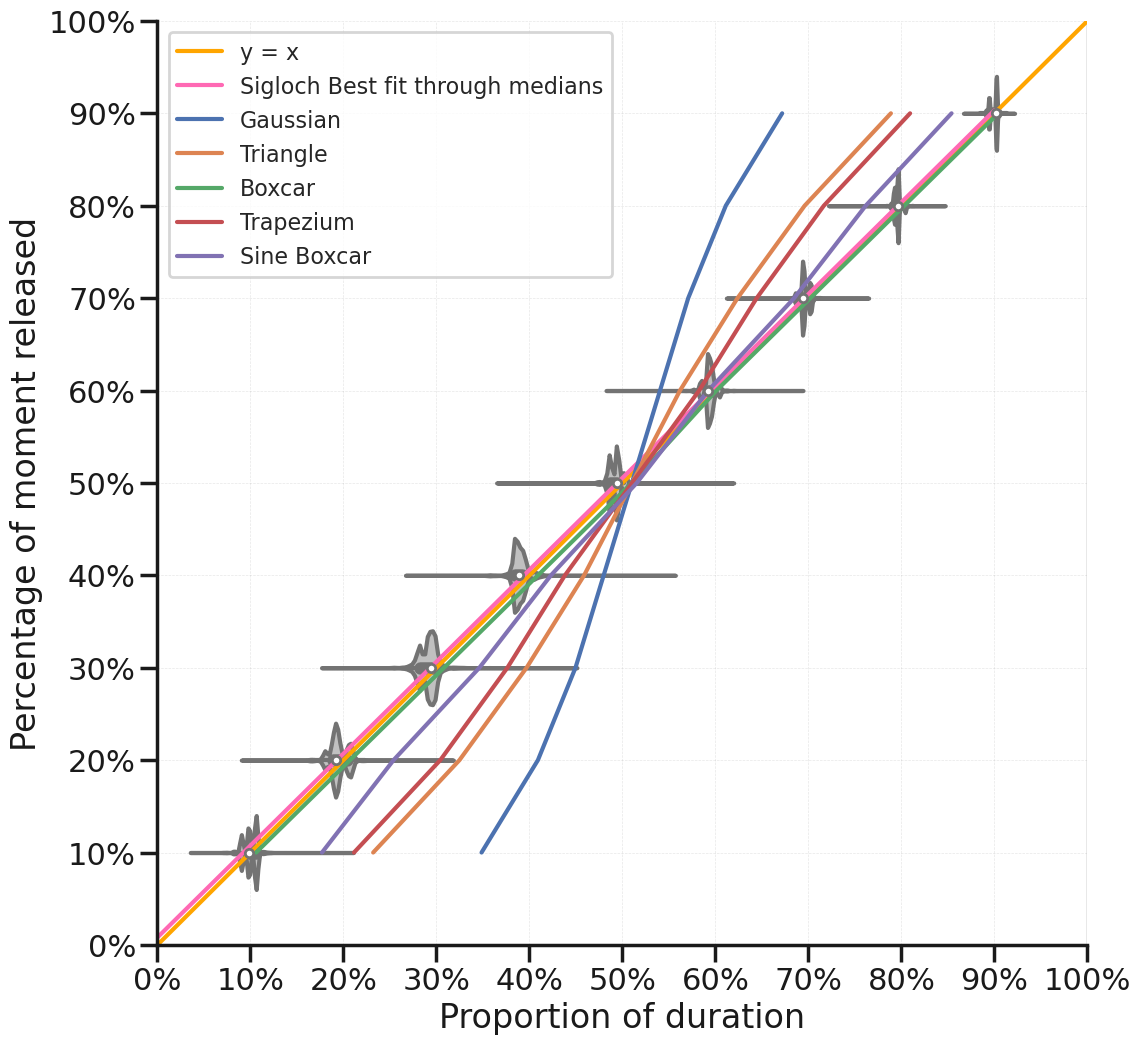

In [107]:
sns.set_theme(style="ticks", context="poster",rc={'figure.figsize':(10,10), "font.size":20})

sns.set_theme(style='ticks',
              context='poster',
              rc={'figure.figsize':(12,12),
                  'font.size':20})

params = {"ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k"}
plt.rcParams.update(params)
plt.rc('legend',fontsize=16)


ax = sns.violinplot(data = all_relative_root_times,
               orient = 'h',
               color = 'silver',
               cut = 0, scale='width')
ax.set_yticks(np.arange(len(np.arange(0, 1.1, 0.1))), [f'{p*100:.0f}%' for p in np.arange(0, 1.1, 0.1)])
ax.set_xticks(np.arange(0, 1.1, 0.1), [f'{p*100:.0f}%' for p in np.arange(0, 1.1, 0.1)])

ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.1, color='k')



ax.set_ylabel('Percentage of moment released')
ax.set_xlabel('Proportion of duration')

ax.invert_yaxis()

ax.plot(np.arange(0, 1.1, 0.1),
        np.arange(0, 11, 1),
        c = 'orange',
        label = 'y = x',)

means = []
medians = []
for i in all_relative_root_times[1:-1]:
    total = np.sum(i)
    #print(total)
    mean = total/len(i)
    #print(mean)
    means.append(mean)
    medians.append(np.median(i))
    #print(np.median(i))

# Calculate the line of best fit
m, b = np.polyfit(means, np.arange(1, 10, 1), 1)
# Plot the line of best fit
# ax.plot(np.mean(all_relative_root_times[1:-1], axis=1),
#         m * np.mean(all_relative_root_times[1:-1], axis=1) + b,
#         c='red',
#         label = 'Mean LoBF',
#         linestyle = '--')

# Calculate the line of best fit
m, b = np.polyfit(medians, np.arange(1, 10, 1), 1)
# Plot the line of best fit
ax.plot(np.arange(0, 1, 0.1),
        m * np.arange(0, 1, 0.1) + b,
        c='hotpink',
        label = 'Sigloch Best fit through medians',
        linestyle = '-')


for funct, label in zip([gaussian, triangle, boxcar, trapezium, sine_boxcar], ['Gaussian', 'Triangle', 'Boxcar', 'Trapezium', 'Sine Boxcar']):
        ax.plot(comparison_calculation(funct), np.arange(1, 10, 1), label = label)

plt.ylim(-0, 10)
plt.xlim(0, 1)

ax.axvspan(1, 1.5, alpha = 0.2, color = 'grey')
plt.legend()
sns.despine()
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/comparisons_to_predictions/violinplot_fraction_of_duration_for_percent_moment_sigloch_only_corrected_ends.png', dpi = 300)
plt.show()

In [91]:
max(all_relative_root_times[1])

0.8394495412844043

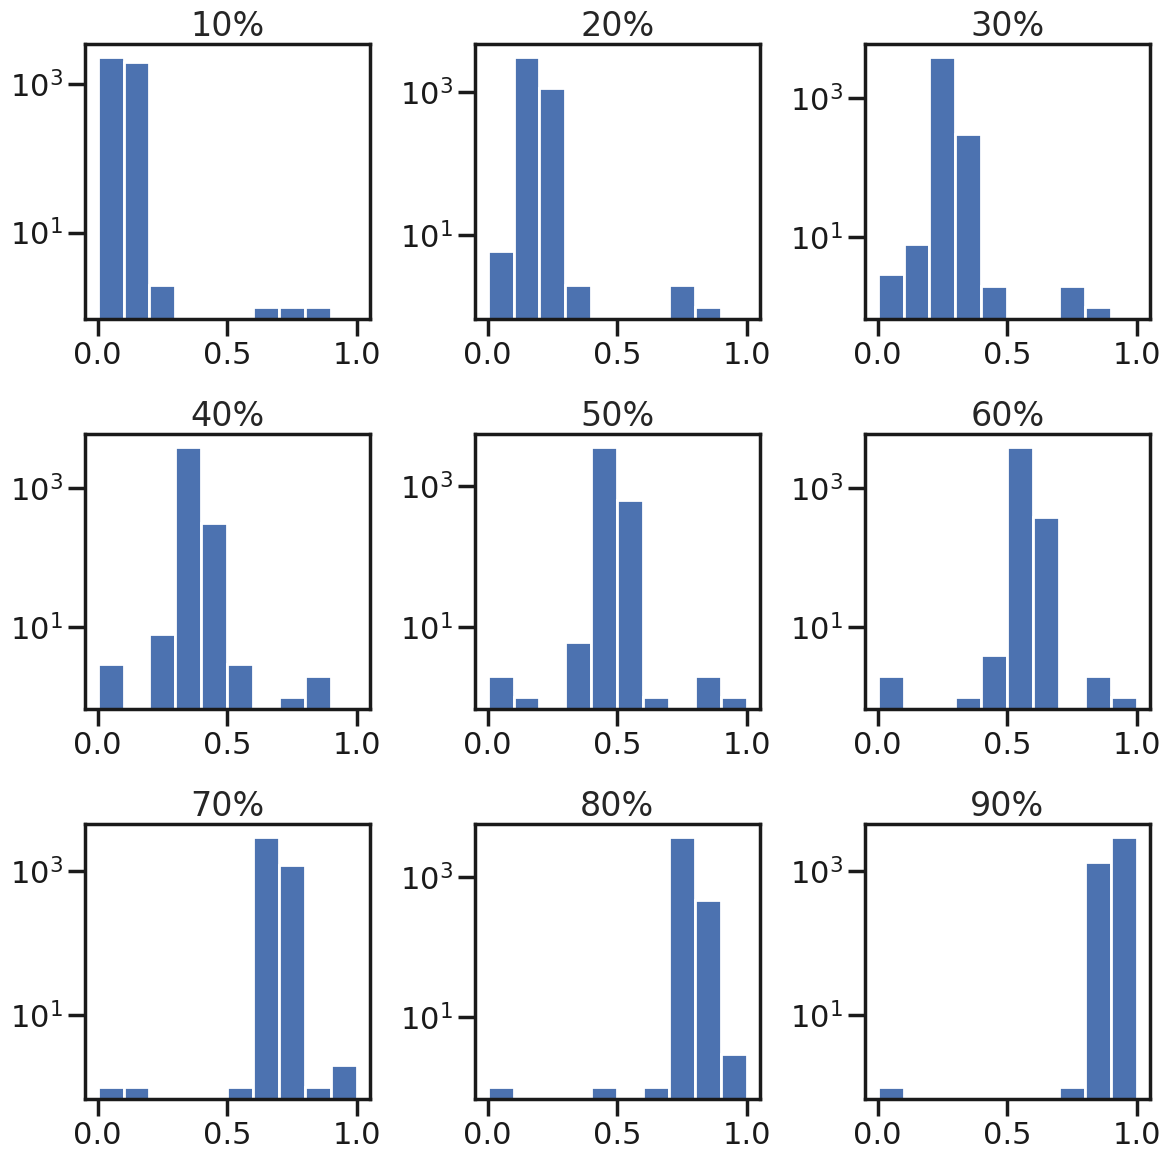

In [63]:
fig, axs = plt.subplots(3,3)
for i in range(9):
    ax = axs[i//3, i%3]
    ax.hist(all_relative_root_times[i+1], bins = np.arange(0 , 1.1, 0.1))
    ax.set_title(f'{proportions_list[i]*100:.0f}%')

    ax.set_yscale('log')

plt.tight_layout()
# plt.hist(all_relative_root_times[1:2])
# plt.yscale('log')

In [25]:
len(all_relative_root_times[2])

4262

In [26]:
combined

,event,scardec,ye,isc,sigloch,usgs,mag
0,20170818_0259,FCTs_20170818_025925_NORTH_OF_ASCENSION_ISLAND,0,0,0,0,6.591
1,20110126_1542,FCTs_20110126_154229_NORTHERN_SUMATRA__INDONESIA,0,0,0706.2011.026.a,0,6.114
2,19981010_1629,FCTs_19981010_162908_MINAHASSA_PENINSULA__SULA...,0,0,0,0,5.927
3,19920730_0824,FCTs_19920730_082446_XIZANG,0,0,0,0,6.017
4,19960327_2052,FCTs_19960327_205206_NEAR_COAST_OF_NICARAGUA,0,0,0,0,6.157
...,...,...,...,...,...,...,...
5610,20230206_1024,0,0,0,0,20230206_102448.txt,NaN
5611,20231202_1437,0,0,0,0,20231202_143704.txt,NaN
5612,19971108_1002,0,0,0,0,19971108_100252.txt,NaN
5613,20181220_1701,0,0,0,0,20181220_170155.txt,NaN


In [69]:
all_relative_root_times_for_event

{'20110126_1542_0': [0.10588235294117648,
  0.207843137254902,
  0.30196078431372547,
  0.39215686274509803,
  0.48627450980392156,
  0.5843137254901961,
  0.6941176470588235,
  0.7921568627450981,
  0.8941176470588236],
 '20011012_1502_0': [0.09803921568627451,
  0.18823529411764708,
  0.29411764705882354,
  0.39607843137254906,
  0.4941176470588236,
  0.596078431372549,
  0.6941176470588235,
  0.7960784313725491,
  0.9019607843137255],
 '20011012_1502_1': [0.09803921568627451,
  0.18039215686274512,
  0.27450980392156865,
  0.38039215686274513,
  0.48627450980392156,
  0.592156862745098,
  0.6862745098039216,
  0.7921568627450981,
  0.8941176470588236],
 '20011012_1502_2': [0.07450980392156863,
  0.16862745098039214,
  0.2666666666666667,
  0.37647058823529417,
  0.47450980392156866,
  0.5843137254901961,
  0.6862745098039216,
  0.7921568627450981,
  0.8941176470588236],
 '20120320_1802_0': [0.10588235294117648,
  0.207843137254902,
  0.3058823529411765,
  0.403921568627451,
  0.4941

20051203_1610_1
20071226_2204_2
20030122_0206_1
20090929_1748_0
20120421_0125_1
20110311_2011_2


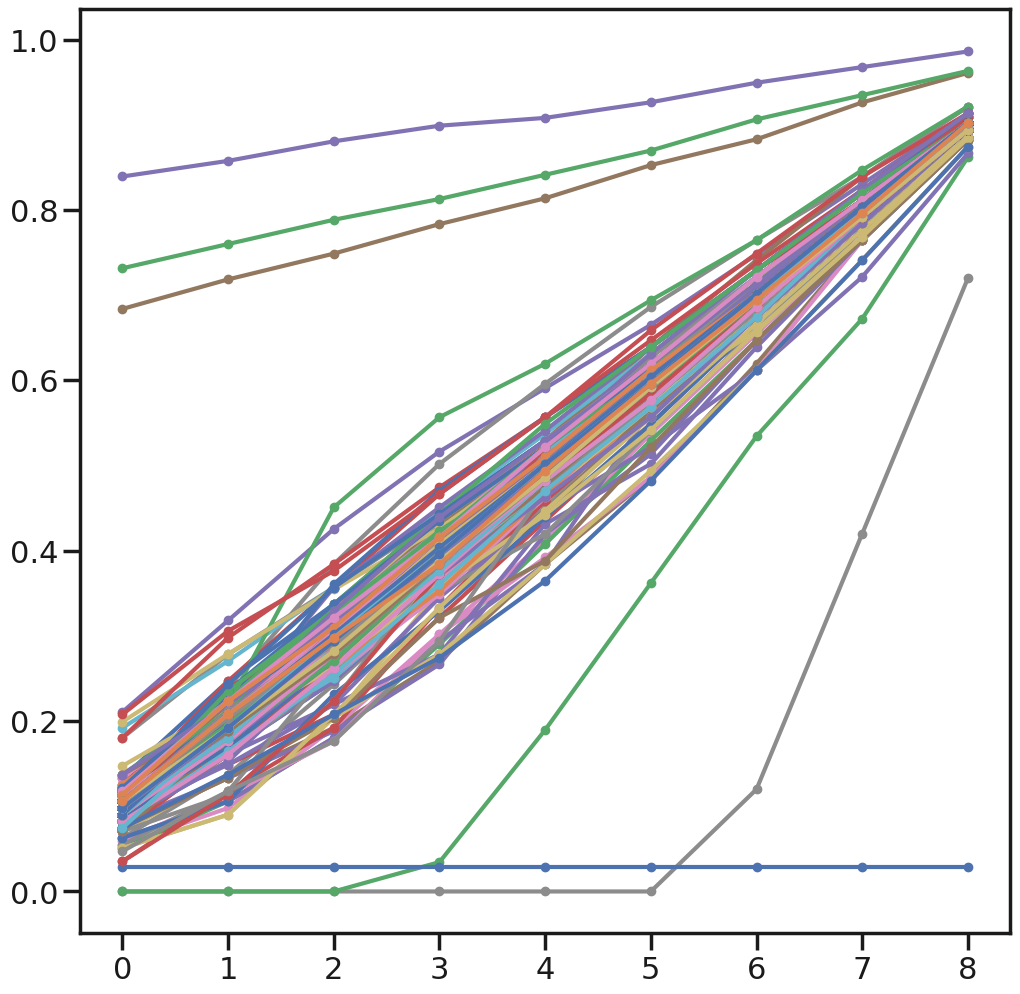

In [75]:
count = 0
for key in all_relative_root_times_for_event.keys():
    plt.plot(np.array(all_relative_root_times_for_event[key]), marker = '.')
    if all_relative_root_times_for_event[key][0] > 0.5:
        print(key)
    if all_relative_root_times_for_event[key][3] < 0.1:
        print(key)
    # count += 1
    # if count > 100:
    #     break
plt.show()

In [76]:
len(durations)

4262

In [77]:
len(moments)

4263